In [1]:
from features import map_sequences_to_features
from aux import load_files, train_validate_split, nfolds_cross_validate, tuples_to_matrices

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc

from scipy import interp

import numpy as np
from matplotlib import pyplot as plt

import itertools
from itertools import cycle


In [2]:
def grid_search():
    file_data = load_files()
    feature_data = map_sequences_to_features(file_data)
    X, Y = tuples_to_matrices(feature_data)

    parameters = { 
        "n_estimators": [200, 300, 400, 450],
        "criterion": ["gini"],
        "n_jobs": [-1]
    }

    estimator = RandomForestClassifier()
    clf = GridSearchCV(estimator, parameters, cv=5)
    clf.fit(X,Y)
    print(clf.best_score_)
    print(clf.best_params_)
    print(clf.cv_results_["mean_test_score"])
    print(clf.cv_results_["params"])

    

In [3]:
def main():
    tv_split = 0.3

    file_data = load_files()
    feature_data = map_sequences_to_features(file_data)
    
    np.random.shuffle(feature_data)

    train, validate = train_validate_split(tv_split, feature_data)
    
    parameters = { 
        "n_estimators": 400,
        "criterion": "gini",
        "n_jobs": -1
    }


    # X, Y = tuples_to_matrices(feature_data)
    model = RandomForestClassifier(**parameters)
    model.fit(*tuples_to_matrices(train))
    valid_acc = model.score(*tuples_to_matrices(validate))
    
    # def run(train, validate):
    #    model.fit(*tuples_to_matrices(train))
    #    return model.score(*tuples_to_matrices(validate))
    #
    # valid_acc = nfolds_cross_validate(5, feature_data, run)
    
    return model, train, validate, valid_acc
    

In [4]:
model, train, validate, acc = main()

['aromaticity', 'end_letter_A', 'end_letter_C', 'end_letter_D', 'end_letter_E', 'end_letter_F', 'end_letter_G', 'end_letter_H', 'end_letter_I', 'end_letter_J', 'end_letter_K', 'end_letter_L', 'end_letter_M', 'end_letter_N', 'end_letter_O', 'end_letter_P', 'end_letter_Q', 'end_letter_R', 'end_letter_S', 'end_letter_T', 'end_letter_U', 'end_letter_V', 'end_letter_W', 'end_letter_Y', 'end_letter_Z', 'frac_A', 'frac_C', 'frac_D', 'frac_E', 'frac_F', 'frac_G', 'frac_H', 'frac_I', 'frac_K', 'frac_L', 'frac_M', 'frac_N', 'frac_P', 'frac_Q', 'frac_R', 'frac_S', 'frac_T', 'frac_V', 'frac_W', 'frac_Y', 'isoelectric', 'molecular_weight', 'seq_length', 'start_letter_A', 'start_letter_C', 'start_letter_D', 'start_letter_E', 'start_letter_F', 'start_letter_G', 'start_letter_H', 'start_letter_I', 'start_letter_J', 'start_letter_K', 'start_letter_L', 'start_letter_M', 'start_letter_N', 'start_letter_O', 'start_letter_P', 'start_letter_Q', 'start_letter_R', 'start_letter_S', 'start_letter_T', 'start_le

In [5]:
def plot_roc_auc(y_test, y_score, label_names):
    n_classes = 4
    lw = 2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(label_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for each class classifier')
    plt.legend(loc="lower right")
    plt.show()

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[518  44 299  25]
 [ 68 246  49  15]
 [273  27 698  19]
 [ 38  21  20 406]]


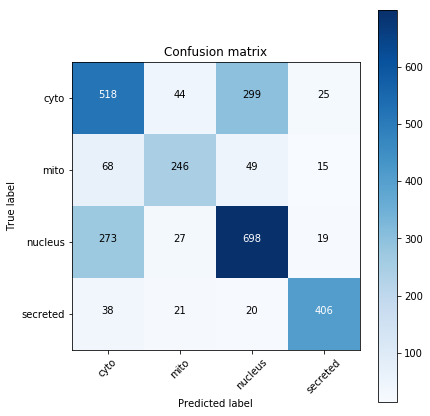

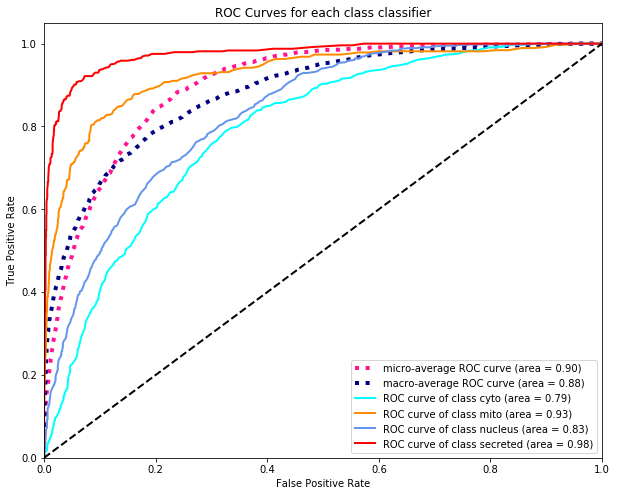

In [7]:
from aux import FILES as labels_fasta 

label_names = [l.replace(".fasta","") for l in labels_fasta]
X_val, Y_val = tuples_to_matrices(validate)
Y_predict_proba = model.predict_proba(X_val)
Y_predict = model.predict(X_val)
cm = confusion_matrix(Y_val, Y_predict)

Y_val_bin = label_binarize(Y_val, classes=[0, 1, 2, 3])
Y_pred_bin = label_binarize(Y_predict, classes=[0, 1, 2, 3])

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, label_names)

plot_roc_auc(Y_val_bin, Y_predict_proba, label_names)


### Dont forget ablation study